In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.metrics import AUC # Area under the curve, default: ROC
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.initializers import GlorotNormal
import kerastuner as kt

In [25]:
def replace_outliers_zeros(data_frame, outlayers_keys: dict, zero_keys: list, mean_median = False, data_to_replace = None):
    """
    Fuction to replace outliers from data_frame
    and replace them with median or mean value
    Don't afect the original data frame, returns a copy 
    with the parameters changed
    """
    data = data_frame.copy()
    if len(zero_keys) != 0:
        for key in zero_keys:
            data.loc[data[key] == 0, key] = np.NaN
            
    replace = {}
    if not data_to_replace:
        for x in data.keys():
            if mean_median:
                replace[x] = np.mean(data[x].dropna())
            else:
                replace[x] = np.median(data[x].dropna())
    else:
        replace = data_to_replace.copy()
        
    for key, val in outlayers_keys.items():
        data.loc[data[key] < val[0], key] = np.NaN
        data.loc[data[key] > val[1], key] = np.NaN
    
    for key, val in replace.items():
        data[key] = data[key].replace(np.NaN, replace[key])
        
    return data, replace


def normalize(data_frame, data_to_norm=None):
    data = data_frame.copy()
    norm_std = {}
    if not data_to_norm:
        for key in data:
            k_mean = np.mean(data[key])
            k_std = np.std(data[key])
            norm_std[key] = [k_mean, k_std]
    else:
        norm_std = data_to_norm.copy()
        
    for key in data:
        data[key] = (data[key]-norm_std[key][0])/norm_std[key][1]
        
    return data, norm_std

def metrics(tn, fp, fn, tp):
    spec = tn / (tn + fp + 1e-15)
    neg_pred_val = tn / (tn + fn + 1e-15)
    sens = tp / (tp + fn + 1e-15)
    pos_pred_val = tp / (tp + fp + 1e-15)
    print('\tEspecificidad: {}\n\tSesitividad: {}\n\tValor predictivo positivo: {}\n\tValor predictivo negativo: {}'.format(spec, 
                                                                                                                    sens, 
                                                                                                                    neg_pred_val, 
                                                                                                                    pos_pred_val))
    
def print_metrics(y, y_pred):
    fpr, tpr, th = roc_curve(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC={}'.format(roc_auc))
    plt.title('ROC Curve')
    plt.show()
    print('PRINCIPAL\n\tArea bajo la curva ROC: {}\nSECUNDARIAS'.format(roc_auc))
    tn, fp, fn, tp = confusion_matrix(y, np.rint(y_pred)).ravel()
    metrics(tn, fp, fn, tp)
    
    
def verify_model(my_model, x_train, y_train, x_validation, y_validation):
    print('Sobre train')
    y_train_pred = my_model.predict(x_train)
    print_metrics(y_train, y_train_pred)
    print('Sobre validation')
    y_valid_pred = my_model.predict(x_validation)
    print_metrics(y_validation, y_valid_pred)
    

def run_tunner(name, model_builder, x_train, y_train, x_validation, y_validation, my_callbacks=[]):
    hyptester = kt.Hyperband(model_builder, 
                             kt.Objective('val_auc', direction='max'), 
                             max_epochs=15, 
                             factor=3,
                             project_name=name,
                             directory='D:/Documents/Keras/models'
                            )
    hyptester.search(x_train, y_train, 
                     epochs=50, 
                     validation_data=(x_validation, y_validation))
    
    hyperparams = hyptester.get_best_hyperparameters(num_trials=2)[0]
    best = hyptester.hypermodel.build(hyperparams)
    history = best.fit(x_train, y_train, epochs=100,
                       validation_data=(x_validation, y_validation), verbose=0,
                       callbacks=my_callbacks)
    return best, history, hyperparams

In [26]:
df = pd.read_csv('../../databases/diabetes.csv')

In [27]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Tomando el EDA del Tp1, se reemplazan los valores no medidos por NaN y se quitan los outlayers para luego reemplazarlos por la media o la mediana

In [28]:
outlayers = {
    'BloodPressure': (40, np.Inf),
    'SkinThickness': (0, 80),
    'Insulin': (0, 400),
    'BMI': (0, 50)
}

zeros = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]

In [29]:
x_data = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_data = df['Outcome']

In [30]:
# Split dataset into 15% test, 85% train 
x, x_test, y, y_test = train_test_split(x_data, y_data, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15)

In [31]:
print('shape train {}, {} '.format(x_train.shape, y_train.shape))
print('shape valid {}, {} '.format(x_valid.shape, y_valid.shape))
print('shape test {}, {} '.format(x_test.shape, y_test.shape))

shape train (554, 8), (554,) 
shape valid (98, 8), (98,) 
shape test (116, 8), (116,) 


In [32]:
x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
x_test_clean, _data = replace_outliers_zeros(x_test, outlayers, zeros, mean_median=True, data_to_replace=_data)
x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)

In [58]:
x_train_clean, _norm_dict = normalize(x_train_clean, None)
x_valid_clean, _norm_dict = normalize(x_valid_clean, _norm_dict)
x_test_clean, _norm_dict = normalize(x_test_clean, _norm_dict)

In [34]:
x_train_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02
mean,-1.034071e-16,2.766289e-16,-5.913841e-16,-9.833289e-15,-3.407824e-15,-5.149311e-16,1.292187e-15,1.402809e-16
std,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00
min,-1.126165e+00,-2.540267e+00,-2.463160e+00,-2.642986e+00,-2.357907e+00,-2.133562e+00,-1.181831e+00,-1.034400e+00
25%,-8.315968e-01,-7.348283e-01,-7.268215e-01,-4.832841e-01,-4.115781e-01,-7.140824e-01,-7.078564e-01,-7.839379e-01
50%,-2.424605e-01,-1.111314e-01,-1.942421e-02,1.485456e-02,1.773506e-01,4.183254e-02,-3.292922e-01,-3.665008e-01
75%,6.412441e-01,6.438701e-01,6.236642e-01,4.338497e-01,1.773506e-01,5.973936e-01,5.155521e-01,6.353484e-01
max,3.881494e+00,2.547787e+00,4.224960e+00,3.984045e+00,4.582775e+00,2.772901e+00,6.007810e+00,3.974845e+00


Primera prueba

In [35]:
def create_model(in_shape, optimizer_, metrics_, loss_, activation_='sigmoid'):
    model = Sequential()
    model.add(Dense(units=1, activation=activation_, input_shape=in_shape))
    model.compile(optimizer=optimizer_,
                  loss= loss_,
                  metrics=metrics_)
    return model

In [36]:
model = create_model(in_shape= (x_train_clean.shape[1],),
                     optimizer_= SGD(momentum=0.9, learning_rate=0.1),
                     metrics_ = [AUC()],
                     loss_ = BinaryCrossentropy(from_logits=True))

Sobre train


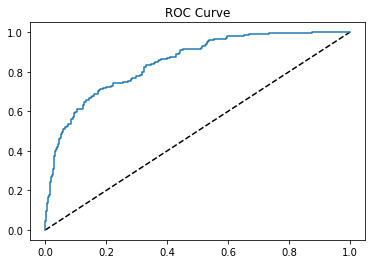

PRINCIPAL
	Area bajo la curva ROC: 0.8484897055180755
SECUNDARIAS
	Especificidad: 0.9455040871934605
	Sesitividad: 0.4919786096256685
	Valor predictivo positivo: 0.7850678733031674
	Valor predictivo negativo: 0.8214285714285714
Sobre validation


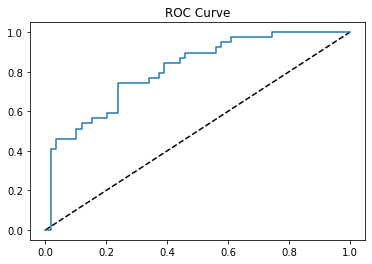

PRINCIPAL
	Area bajo la curva ROC: 0.8122555410691004
SECUNDARIAS
	Especificidad: 0.9830508474576272
	Sesitividad: 0.41025641025641024
	Valor predictivo positivo: 0.7160493827160493
	Valor predictivo negativo: 0.9411764705882353


In [37]:
model.fit(x_train_clean, y_train, epochs=40,shuffle=True, validation_data=(x_valid_clean, y_valid), verbose=0)
verify_model(model, x_train_clean, y_train, x_valid_clean, y_valid)

In [38]:
def model_builder(hp):
    model = Sequential()
    model.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_clean.shape[1],)))
    
    # Optimizadores a porbar
    optimizer_type = hp.Choice('optimizer_type', values=['SGD', 'Adam']) 
    # Hyperparametros para porbar en el optimizador
    _learning_rate_ = hp.Float('learning_rate', min_value=1e-3, max_value=3.3, sampling='LOG')
    _momentum_ = hp.Choice('momentum', values=[0.5, 0.75, 0.85, 0.9, 0.99, 0.999])
    
    if optimizer_type == 'SGD':
        _optimizer_ = SGD(learning_rate=_learning_rate_, momentum=_momentum_)
    else:
        _optimizer_ = Adam(learning_rate=_learning_rate_)
    
    _metrics_ = [AUC()]
    _loss_ = BinaryCrossentropy(from_logits=True)
    
    model.compile(optimizer=_optimizer_,
                  loss=_loss_,
                  metrics=_metrics_)
    
    return model


Sin alterar el dataser inicial y buscando la mejor combinacion de hyperparámetros

Trial 30 Complete [00h 00m 02s]
val_auc: 0.504128634929657

Best val_auc So Far: 0.6029987335205078
Total elapsed time: 00h 00m 50s
INFO:tensorflow:Oracle triggered exit
best momentum 0.75
best learning_rate 0.0018703817269442302
best optimizer Adam
Sobre train


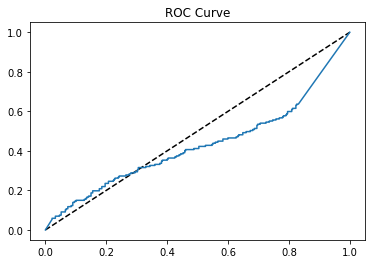

PRINCIPAL
	Area bajo la curva ROC: 0.43006600708155446
SECUNDARIAS
	Especificidad: 0.9673024523160763
	Sesitividad: 0.06951871657754011
	Valor predictivo positivo: 0.6710775047258979
	Valor predictivo negativo: 0.52
Sobre validation


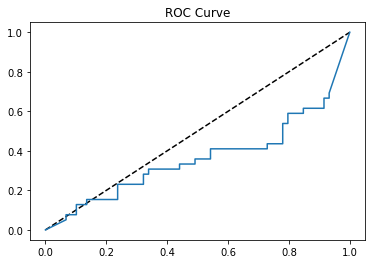

PRINCIPAL
	Area bajo la curva ROC: 0.36332029552368533
SECUNDARIAS
	Especificidad: 0.9152542372881356
	Sesitividad: 0.07692307692307693
	Valor predictivo positivo: 0.6
	Valor predictivo negativo: 0.37499999999999994


In [39]:
best_model, hist, hyperparams = run_tunner("regresion_04_raw", model_builder, x_train, y_train, x_valid, y_valid)

print('best momentum',hyperparams.get('momentum'))
print('best learning_rate',hyperparams.get('learning_rate'))
print('best optimizer', hyperparams.get('optimizer_type'))

verify_model(best_model, x_train, y_train, x_valid, y_valid)

Ahora aplicando el EDA y sacando los valores nulos y outlayers

INFO:tensorflow:Reloading Oracle from existing project D:/Documents/Keras/models\regresion_04_proc\oracle.json
INFO:tensorflow:Reloading Tuner from D:/Documents/Keras/models\regresion_04_proc\tuner0.json
INFO:tensorflow:Oracle triggered exit
best momentum 0.85
best learning_rate 0.028476203359694054
best optimizer Adam
Sobre train


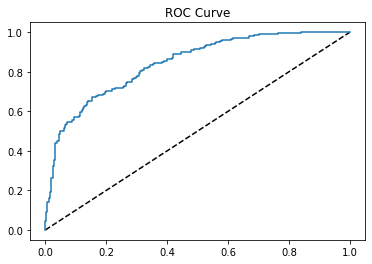

PRINCIPAL
	Area bajo la curva ROC: 0.8418598551632692
SECUNDARIAS
	Especificidad: 0.9509536784741145
	Sesitividad: 0.49732620320855614
	Valor predictivo positivo: 0.7878103837471784
	Valor predictivo negativo: 0.8378378378378378
Sobre validation


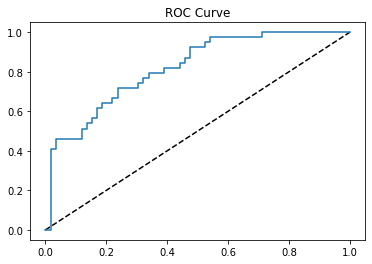

PRINCIPAL
	Area bajo la curva ROC: 0.8187744458930899
SECUNDARIAS
	Especificidad: 0.9661016949152542
	Sesitividad: 0.41025641025641024
	Valor predictivo positivo: 0.7125
	Valor predictivo negativo: 0.8888888888888888


In [59]:
best_model, hist, hyperparams = run_tunner("regresion_04_proc", model_builder, x_train_clean, y_train, x_valid_clean, y_valid)

print('best momentum',hyperparams.get('momentum'))
print('best learning_rate',hyperparams.get('learning_rate'))
print('best optimizer', hyperparams.get('optimizer_type'))

verify_model(best_model, x_train_clean, y_train, x_valid_clean, y_valid)

Tambien probamos removiendo algunas columnas

In [43]:
col_to_remove = ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction']
# ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
# ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
x_train_reduce = x_train_clean.drop(col_to_remove, inplace=False, axis=1)
x_valid_reduce = x_valid_clean.drop(col_to_remove, inplace=False, axis=1)

def model_builder_2(hp):
    model = Sequential()
    model.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_reduce.shape[1],)))
    
    # Optimizadores a porbar
    optimizer_type = hp.Choice('optimizer_type', values=['SGD', 'Adam']) 
    # Hyperparametros para porbar en el optimizador
    _learning_rate_ = hp.Float('learning_rate', min_value=1e-3, max_value=3.3, sampling='LOG')
    _momentum_ = hp.Choice('momentum', values=[0.5, 0.75, 0.85, 0.9, 0.99, 0.999])
    
    if optimizer_type == 'SGD':
        _optimizer_ = SGD(learning_rate=_learning_rate_, momentum=_momentum_)
    else:
        _optimizer_ = Adam(learning_rate=_learning_rate_)
    
    _metrics_ = [AUC()]
    _loss_ = BinaryCrossentropy(from_logits=True)
    
    model.compile(optimizer=_optimizer_,
                  loss=_loss_,
                  metrics=_metrics_)
    
    return model


Trial 30 Complete [00h 00m 03s]
val_auc: 0.8055193424224854

Best val_auc So Far: 0.8098652362823486
Total elapsed time: 00h 00m 56s
INFO:tensorflow:Oracle triggered exit
best momentum 0.5
best learning_rate 0.025595184730695563
best optimizer Adam
Sobre train


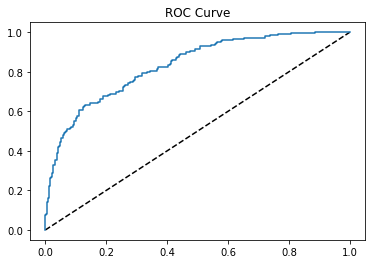

PRINCIPAL
	Area bajo la curva ROC: 0.8317329408850487
SECUNDARIAS
	Especificidad: 0.9455040871934605
	Sesitividad: 0.46524064171123
	Valor predictivo positivo: 0.7762863534675615
	Valor predictivo negativo: 0.8130841121495327
Sobre validation


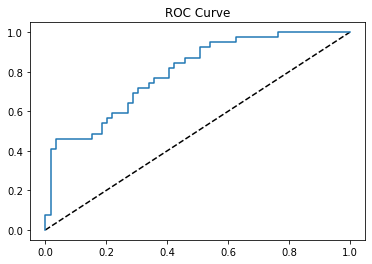

PRINCIPAL
	Area bajo la curva ROC: 0.7948717948717949
SECUNDARIAS
	Especificidad: 0.9830508474576272
	Sesitividad: 0.3333333333333333
	Valor predictivo positivo: 0.6904761904761905
	Valor predictivo negativo: 0.9285714285714285


In [45]:
best_model_process, hist, hyperparams = run_tunner("regresion_03_reduce", model_builder_2, x_train_reduce, y_train, x_valid_reduce, y_valid)

print('best momentum',hyperparams.get('momentum'))
print('best learning_rate',hyperparams.get('learning_rate'))
print('best optimizer', hyperparams.get('optimizer_type'))

verify_model(best_model_process, x_train_reduce, y_train, x_valid_reduce, y_valid)

In [64]:
def model_builder_init(hp):
    model = Sequential()
    initializer = GlorotNormal()
    
    model.add(Dense(units=1, kernel_initializer=initializer, activation='sigmoid', input_shape=(x_train_clean.shape[1],)))
    
    # Optimizadores a porbar
    optimizer_type = hp.Choice('optimizer_type', values=['SGD', 'Adam']) 
    # Hyperparametros para porbar en el optimizador
    _learning_rate_ = hp.Float('learning_rate', min_value=1e-3, max_value=3.3, sampling='LOG')
    _momentum_ = hp.Choice('momentum', values=[0.5, 0.75, 0.85, 0.9, 0.99, 0.999])
    
    if optimizer_type == 'SGD':
        _optimizer_ = SGD(learning_rate=_learning_rate_, momentum=_momentum_)
    else:
        _optimizer_ = Adam(learning_rate=_learning_rate_)
    
    _metrics_ = [AUC()]
    _loss_ = BinaryCrossentropy(from_logits=True)
    
    model.compile(optimizer=_optimizer_,
                  loss=_loss_,
                  metrics=_metrics_)
    
    return model


Trial 30 Complete [00h 00m 04s]
val_auc: 0.6427639722824097

Best val_auc So Far: 0.8070404529571533
Total elapsed time: 00h 01m 03s
INFO:tensorflow:Oracle triggered exit
best momentum 0.5
best learning_rate 2.747448179484898
best optimizer SGD
Sobre train


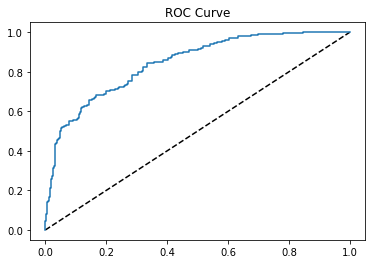

PRINCIPAL
	Area bajo la curva ROC: 0.8427924055428464
SECUNDARIAS
	Especificidad: 0.9509536784741145
	Sesitividad: 0.49732620320855614
	Valor predictivo positivo: 0.7878103837471784
	Valor predictivo negativo: 0.8378378378378378
Sobre validation


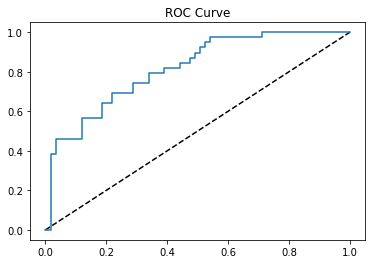

PRINCIPAL
	Area bajo la curva ROC: 0.816166883963494
SECUNDARIAS
	Especificidad: 0.9661016949152542
	Sesitividad: 0.4358974358974359
	Valor predictivo positivo: 0.7215189873417721
	Valor predictivo negativo: 0.8947368421052632


In [65]:
best_model, hist, hyperparams = run_tunner("regresion_01_init", model_builder_init, x_train_clean, y_train, x_valid_clean, y_valid)

print('best momentum',hyperparams.get('momentum'))
print('best learning_rate',hyperparams.get('learning_rate'))
print('best optimizer', hyperparams.get('optimizer_type'))

verify_model(best_model, x_train_clean, y_train, x_valid_clean, y_valid)

# Early Stopping

Detiene el entrenamiento de forma anticipada si se llega a cierto valor de un parametro determinado, en principio permite agilizar las pruebas al buscar hyperparámetros, descartanto rapidamenete las combinacion que converjan rapidamente a un valor esperado

Los hyperparámetrso principales de este callback son:
- monitor: indica la variable a monitorear (valga la redundancia)
- min_delta: la minima diferencia que se considera como mejora
- patience: cantidad de epochs sin mejoras antes de parar

In [46]:
stop_early = EarlyStopping(monitor='val_auc', patience=15)

Trial 30 Complete [00h 00m 04s]
val_auc: 0.7448935508728027

Best val_auc So Far: 0.8183398842811584
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit
best momentum 0.99
best learning_rate 0.00473683101339036
best optimizer Adam
Sobre train


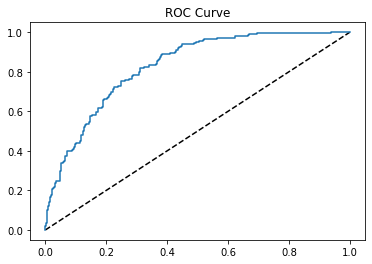

PRINCIPAL
	Area bajo la curva ROC: 0.8273907531801425
SECUNDARIAS
	Especificidad: 0.8174386920980926
	Sesitividad: 0.6149732620320856
	Valor predictivo positivo: 0.8064516129032258
	Valor predictivo negativo: 0.6318681318681318
Sobre validation


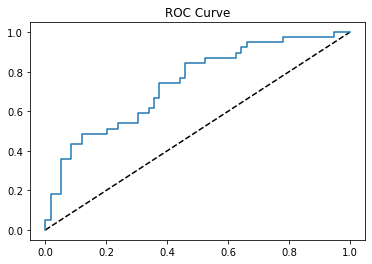

PRINCIPAL
	Area bajo la curva ROC: 0.7396784006953498
SECUNDARIAS
	Especificidad: 0.7966101694915254
	Sesitividad: 0.5128205128205128
	Valor predictivo positivo: 0.7121212121212122
	Valor predictivo negativo: 0.625


In [47]:
early_model, hist, hyperparams = run_tunner("regresion_early_00", model_builder, x_train_clean, y_train, x_valid_clean, y_valid, my_callbacks=[stop_early])

# Get the optimal hyperparameters
print('best momentum',hyperparams.get('momentum'))
print('best learning_rate',hyperparams.get('learning_rate'))
print('best optimizer', hyperparams.get('optimizer_type'))
verify_model(early_model, x_train_clean, y_train, x_valid_clean, y_valid)

Se puede ver que los resultados sobre el set de validación son similares, lo que fue beneficioso al utilizar el earlystopping fue la posibilidad de probar una mayor cantidad de combinaciónes de hyperparámetros en un tiempo similar, obteniendo asi una combinación de hyperparámetros más confiable

# Learning Rate Scheduler

Permite ajustar el learning rate en funcion del epoch que se esta trabajando, por lo tanto dependiendo la funcion de costos minimizarla de forma más rapida y eficiente???

In [51]:
def schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

In [52]:
scheduler = LearningRateScheduler(schedule)

Trial 30 Complete [00h 00m 01s]
val_auc: 0.7379400730133057

Best val_auc So Far: 0.8152977228164673
Total elapsed time: 00h 01m 09s
INFO:tensorflow:Oracle triggered exit
best momentum 0.75
best learning_rate 0.047893502652158366
best optimizer Adam
Sobre train


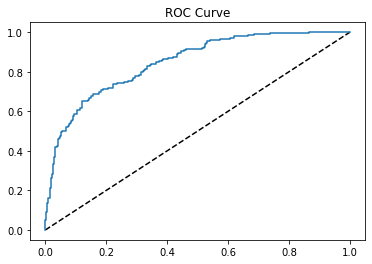

PRINCIPAL
	Area bajo la curva ROC: 0.8470034533506243
SECUNDARIAS
	Especificidad: 0.9455040871934605
	Sesitividad: 0.5026737967914439
	Valor predictivo positivo: 0.7886363636363637
	Valor predictivo negativo: 0.8245614035087719
Sobre validation


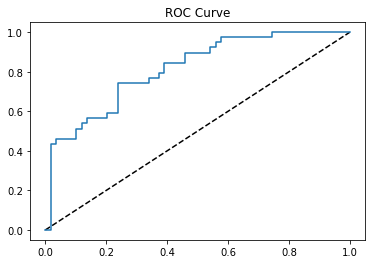

PRINCIPAL
	Area bajo la curva ROC: 0.8144285093437635
SECUNDARIAS
	Especificidad: 0.9830508474576272
	Sesitividad: 0.4358974358974359
	Valor predictivo positivo: 0.725
	Valor predictivo negativo: 0.9444444444444444


In [53]:
schedule_model, hist, hyperparams = run_tunner("regresion_schedule_01", model_builder, x_train_clean, y_train, x_valid_clean, y_valid, 
                                            my_callbacks=[scheduler])

# Get the optimal hyperparameters
print('best momentum',hyperparams.get('momentum'))
print('best learning_rate',hyperparams.get('learning_rate'))
print('best optimizer', hyperparams.get('optimizer_type'))
verify_model(schedule_model, x_train_clean, y_train, x_valid_clean, y_valid)


# Model CheckPoint & Tensorboard

# Tecnicas de Regularización

*   Drop out

Lleva a 0 algunas entradas de forma aleatorea, reduciendo el espacio de soluciones del sistema, buscando evitar el overfiting

*   Regularización L1
*   Regularización L2
*   Batch Normalization


In [54]:
def model_builder_drop(hp):
    model = Sequential()
    drop_out = hp.Choice('drop_out_rate', values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.27, 0.39, 0.5] )
    model.add(Dropout(rate=drop_out, input_shape=(x_train_clean.shape[1],)))
    model.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_clean.shape[1],)))
    
    # Optimizadores a porbar
    optimizer_type = hp.Choice('optimizer_type', values=['SGD', 'Adam']) 
    # Hyperparametros para porbar en el optimizador
    _learning_rate_ = hp.Float('learning_rate', min_value=1e-3, max_value=3.3, sampling='LOG')
    _momentum_ = hp.Choice('momentum', values=[0.5, 0.75, 0.85, 0.9, 0.99, 0.999])
    
    if optimizer_type == 'SGD':
        _optimizer_ = SGD(learning_rate=_learning_rate_, momentum=_momentum_)
    else:
        _optimizer_ = Adam(learning_rate=_learning_rate_)
    
    _metrics_ = [AUC()]
    _loss_ = BinaryCrossentropy(from_logits=True)
    
    model.compile(optimizer=_optimizer_,
                  loss=_loss_,
                  metrics=_metrics_)
    
    return model


Trial 30 Complete [00h 00m 04s]
val_auc: 0.7807475328445435

Best val_auc So Far: 0.8042155504226685
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit
best momentum 0.75
best learning_rate 0.12406767601844099
best optimizer Adam
best drop out rate 0.1
Sobre train


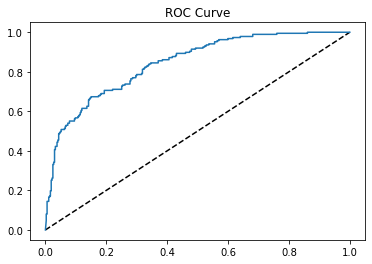

PRINCIPAL
	Area bajo la curva ROC: 0.8425519823981116
SECUNDARIAS
	Especificidad: 0.9536784741144414
	Sesitividad: 0.48663101604278075
	Valor predictivo positivo: 0.7847533632286996
	Valor predictivo negativo: 0.8425925925925926
Sobre validation


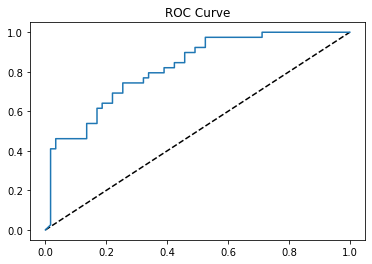

PRINCIPAL
	Area bajo la curva ROC: 0.8198609300304215
SECUNDARIAS
	Especificidad: 0.9830508474576272
	Sesitividad: 0.41025641025641024
	Valor predictivo positivo: 0.7160493827160493
	Valor predictivo negativo: 0.9411764705882353


In [55]:
drop_model, hist, hyperparams = run_tunner("regresion_drop_00", model_builder_drop, x_train_clean, y_train, x_valid_clean, y_valid)

print('best momentum',hyperparams.get('momentum'))
print('best learning_rate',hyperparams.get('learning_rate'))
print('best optimizer', hyperparams.get('optimizer_type'))
print('best drop out rate', hyperparams.get('drop_out_rate'))

verify_model(drop_model, x_train_clean, y_train, x_valid_clean, y_valid)